### Fitting XShooter data with xtool ###

In [1]:
from xtool.data import XShooterData, Order
from xtool.model.order_models import GenericBackground, MoffatTrace, SlopedMoffatTrace
from xtool.model.base import OrderModel, VirtualPixelWavelength

from scipy import sparse
from scipy import optimize

#### Reading XShooter data ####

In [2]:
xd = XShooterData('xtool_ds/')

In [3]:
current_order = xd[17]
current_order.enable_flags_as_mask() # important to update the data to include the bad pixels from the pipeline

#### Generating a virtual pixel table for "Wavelength"-pixels ####

In [4]:
virt_pix = VirtualPixelWavelength.from_order(current_order)
pixel_table = virt_pix()

#### Initializing the two Models ####

In [5]:
background_mdl = GenericBackground(pixel_table, virt_pix.wavelength_pixels)
#trace_mdl = MoffatTrace(pixel_table)
trace_mdl = SlopedMoffatTrace(pixel_table, virt_pix.wavelength_pixels)

In [6]:
order_model = OrderModel([background_mdl, trace_mdl])

#### Show fittable parameters ####

In [7]:
order_model

<OrderModel(background_level=[  0.00000000e+00   0.00000000e+00   1.33800000e+03 ...,   2.00000000e+00
   1.00000000e+00   0.00000000e+00], amplitude=[ nan  nan  nan ...,  nan  nan  nan], trace_pos=0.0, trace_slope=0.0, sigma=1.0, beta=1.5 [f])>

#### Initializing the fitter ####

In [8]:
from xtool.model.fitters import Fitter

In [9]:
fitter = Fitter(order_model, current_order)

#### Differential Evolution fit ####

Differential evolution is a very thorough but slow processs. It does not use starting values but moves within the bounds of the parameters. 

In [10]:
order_model.beta.fixed = False
dresult = fitter.fit_differential_evolution(disp=True)

differential_evolution step 1: f(x)= 4.30042e+06
differential_evolution step 2: f(x)= 4.04298e+06
differential_evolution step 3: f(x)= 4.04298e+06
differential_evolution step 4: f(x)= 3.88995e+06
differential_evolution step 5: f(x)= 3.81197e+06
differential_evolution step 6: f(x)= 3.81197e+06
differential_evolution step 7: f(x)= 3.42761e+06
differential_evolution step 8: f(x)= 2.78918e+06
differential_evolution step 9: f(x)= 2.78918e+06
differential_evolution step 10: f(x)= 2.45386e+06
differential_evolution step 11: f(x)= 2.45386e+06
differential_evolution step 12: f(x)= 2.45386e+06
differential_evolution step 13: f(x)= 2.08132e+06
differential_evolution step 14: f(x)= 2.08132e+06
differential_evolution step 15: f(x)= 1.95347e+06
differential_evolution step 16: f(x)= 1.95347e+06
differential_evolution step 17: f(x)= 1.9435e+06
differential_evolution step 18: f(x)= 1.9343e+06
differential_evolution step 19: f(x)= 1.90473e+06
differential_evolution step 20: f(x)= 1.90298e+06
differentia

In [11]:
dresult

     fun: 1902651.3138355378
 message: 'Optimization terminated successfully.'
    nfev: 1164
     nit: 23
 success: True
       x: array([-2.4418093 , -0.33291377,  0.18789056])

#### Nelder Mead / Simplex ####

This one is much faster algorithm that will use starting values, but is unbounded

In [10]:

order_model.trace_pos = -2
order_model.sigma = 0.1
order_model.trace_slope = 0.
order_model.beta.fixed = False
order_model.beta = 2.0
result = fitter.fit_scipy_minimize('Nelder-Mead')

/Users/wkerzend/anaconda3/envs/xtool/lib/python2.7/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


Fit finished in 214.419122219 s


/Users/wkerzend/anaconda3/envs/xtool/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:243: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/wkerzend/anaconda3/envs/xtool/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:161: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [11]:
result

 final_simplex: (array([[-2.43994097,  0.0029923 ,  0.19864098,  2.14546372],
       [-2.43994097,  0.0029923 ,  0.19864098,  2.1454637 ],
       [-2.43994096,  0.0029923 ,  0.19864097,  2.14546366],
       [-2.43994096,  0.0029923 ,  0.19864097,  2.14546367],
       [-2.43994096,  0.0029923 ,  0.19864097,  2.14546362]]), array([ 1896160.74067645,  1896160.74067645,  1896160.74067645,
        1896160.74067645,  1896160.74067645]))
           fun: 1896160.7406764471
       message: 'Optimization terminated successfully.'
          nfev: 294
           nit: 142
        status: 0
       success: True
             x: array([-2.43994097,  0.0029923 ,  0.19864098,  2.14546372])

#### Plotting in DS9 ####

In [13]:
import pyds9

In [14]:
d = pyds9.DS9()

In [15]:
order_model.trace_pos = result.x[0]
order_model.trace_slope = result.x[1]
order_model.sigma = result.x[2]
order_model.beta = result.x[3]
model = order_model.evaluate_to_frame(current_order, trace_pos=order_model.trace_pos, 
                                      trace_slope=order_model.trace_slope, sigma=order_model.sigma, beta=order_model.beta.value)
d.set('frame 1')
d.set_np2arr(current_order.data.filled())

d.set('frame 2')
d.set_np2arr(model.filled())

d.set('frame 3')
d.set_np2arr((current_order.data.filled() - model.filled())/current_order.uncertainty.filled())


1

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


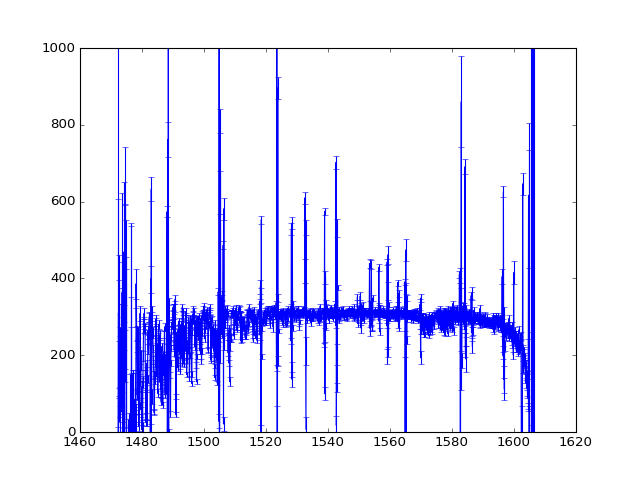

(0, 1000)

In [21]:
%pylab nbagg
spec = order_model[1].to_spectrum()
errorbar(spec.wavelength.value, spec.flux, spec.uncertainty)
ylim(0, 1000)